# Analyse de désabonnement sur plateforme en ligne

## Introduction

Pendant la crise sanitaire internationale , j'ai participé au développement de l'application Fitroulette et à son déploiement. Fitroulette est la première application de partage de séance sportive avec un "Fitbuddy" choisi en fonction de des équipements, niveaux sportifs et disponibilités.

L'une des idées sur laquelle nous nous sommes basé est : ' le retour à l'expérience'. En effet, nous espérons qu'un client ayant utilisé notre application l'utilisera plus fréquement. Le pool d'utilisateurs connecté à un interval de temps donné  fait la force de l'application  en augmentant le nombre de pairs d'utilisateurs pouvant matcher.
 
La prévention de désabonnement dans le cas de Fitroulette est aussi importante que celle de l'acquisition.

Nous essayerons dans ce projet d'analyser et de prédire les désabonnements sur une plateforme en ligne. L'objectif sera de réussir à expliquer les raisons poussant les utilisateurs à se désabonner.

L'objectif sera de construire et comparer deux modèles : un basé sur l'agrégation des informations des logs utilisateurs et le deuxième modèle se basera sur une approche séquentielle. 

Nous espérons comparer les résultats des deux méthodes et analyser les features ayants le plus d'impact sur le désabonnement. 

In [108]:
#
# Import modules
#
import pickle
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from keras.callbacks import EarlyStopping
from keras.models import load_model
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    auc,
    confusion_matrix,
    plot_confusion_matrix,
    plot_roc_curve,
    recall_score,
    roc_curve,
    recall_score
)
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (
    LSTM,
    Activation,
    Concatenate,
    Dense,
    Flatten,
    Input,
    Lambda,
    Multiply,
    Permute,
    RepeatVector,
)
from tensorflow.keras.metrics import AUC, Recall
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model
from tqdm import tqdm

warnings.filterwarnings("ignore")


pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 100)
%config IPCompleter.greedy=True

In [212]:
from IPython.core.display import HTML
def css_styling():
    styles = open("custom.css", "r").read() #or edit path to custom.css
    return HTML(styles)
css_styling()


## Analyse des données


### Description des données

La base de données à disposition a été créé à partir de données d'un site en ligne proposant un service à la souscription. 

* La base **users** contient ~9000 profils avec une indication de désabonnement
* La base données comporte deux tables:
    * Users:
        * Uid - Id utilisateur
        * location - Id de la region renseignée par l'utilisateur
        * age -  age
        * gender - homme /femme
        * registration_channel - Id du canal utilisé pour s'enregistrer
        * registration_date - date d'enregistrement
        * is_churn - L'utilisateur s'est désabonné (1 - oui / 0 - non)
    * Logs:
        * Uid - Id utilisateur
        * date - Date d'enregistrement de l'activité
        * views - nombres d'objets média visionné
        * items - nombres d'objets médias sur lesquels l'utilisateurs à cliquer
        * duration - durée journalière de connexion (en s)
        * previews - nombres d'objets médias prévisionnés

### Import des données

In [208]:
data_path = "data/"
users = pd.read_csv(
    data_path + "users.csv.zip",
    compression="zip",
    index_col="uid",
    parse_dates=["registration_date"],
)
logs = pd.read_csv(
    data_path + "usage_logs.csv.zip",
    compression="zip",
    index_col="uid",
    parse_dates=["date"],
)

### Données manquantes

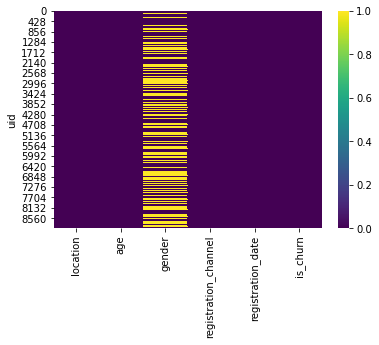

In [197]:
sns.heatmap(users.isna(), cmap="viridis")

<AxesSubplot:ylabel='uid'>

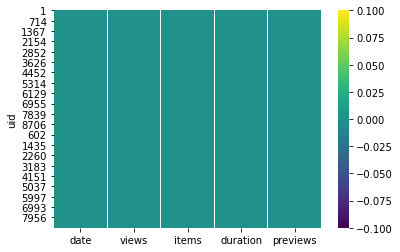

In [19]:
sns.heatmap(logs.isna(), cmap="viridis")

> Nous remarquons beaucoup de données manquantes dans la colonne Gender, nous pouvons remédier à cela dans le pipeline training. 

> Nous remarquons aussi qu'il n'y aucune data missing dans les logs ( normal)

La première étape d'analyse a été comparer le nombres des utilisateurs ayant pris la décision de se désabonner dans notre table  **users**.

> Nous avons un problème de classification balancé. 

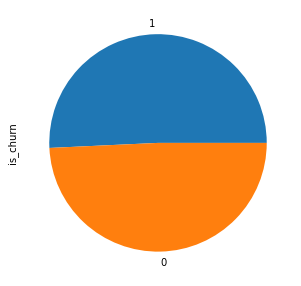

In [201]:
is_churn = users["is_churn"].value_counts() / len(users.is_churn)

plot = is_churn.plot.pie(figsize=(5, 5))

plt.savefig("churn_distribution.png")

In [165]:
users.columns

Index(['location', 'age', 'gender', 'registration_channel', 'is_churn', 'days_registered'], dtype='object')

In [102]:
#  valeurs abbérantes pour le
users.age.describe()

count    8979.000000
mean       15.051231
std        18.008910
min       -43.000000
25%         0.000000
50%        18.000000
75%        27.000000
max       810.000000
Name: age, dtype: float64

In [103]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8979 entries, 0 to 8978
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   location              8979 non-null   int64         
 1   age                   8979 non-null   int64         
 2   gender                4681 non-null   object        
 3   registration_channel  8979 non-null   int64         
 4   registration_date     8979 non-null   datetime64[ns]
 5   is_churn              8979 non-null   int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 491.0+ KB


### Analyse statistique

#### Impact de l'âge sur le désabonnement

In [105]:
users_age = users[users["age"].between(0, 90)]

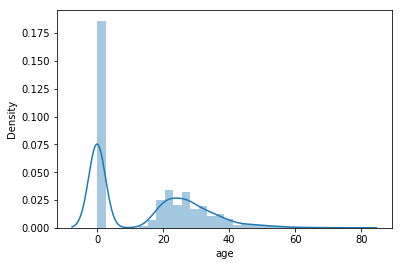

In [111]:
sns.distplot(users_age.age)

plt.savefig("age distribution.png")

In [206]:
print(
    "{:.2%}% des utilisateurs ont renseigné 0 comme age".format(
        sum(users.age == 0) / len(users.age)
    )
)

47.72%% des utilisateurs ont renseigné 0 comme age


Ceci indique surement que ces derniers ne voulaient pas renseigner leur age. Nous allons donc transformer cette colonne pour mapper les valeurs abbérantes de l'age à 0.

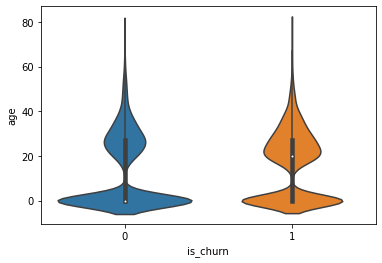

In [91]:
users["age"] = users["age"].apply(lambda x: 0 if (x < 0 or x > 90) else x)

sns.violinplot(x="is_churn", y="age", data=users)

plt.savefig("churn_distribution_churn.png")

> Après traitement de la feature age, nous ne remarquons que les désabonnements sont un peu moins concentré sur la moyenne des ages que pour les utilisateurs restants.

#### Impact du sexe sur le désabonnement

Text(0, 0.5, 'Count')

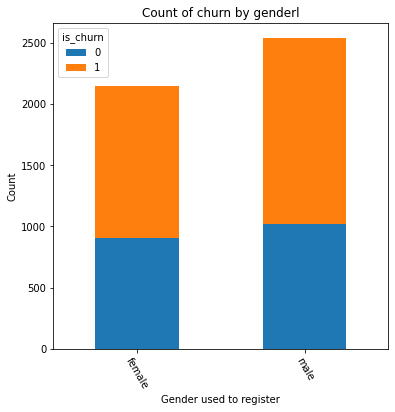

In [94]:
# Count of  churned user by gender
# The na values are automatically
data_req = users.groupby(["gender", "is_churn"]).size().unstack(level=1)
data_req.plot(kind="bar", stacked=True, figsize=(6, 6))
plt.title("Count of churn by genderl")
plt.xlabel("Gender used to register", fontsize=10)
plt.xticks(rotation=300)
plt.ylabel("Count", fontsize=10)

> Nous remarquons qu'il n'y a pas de différence notable de churn entre les hommes et les femmes

#### Impact du Canal d'enregistrement sur le désabonnement

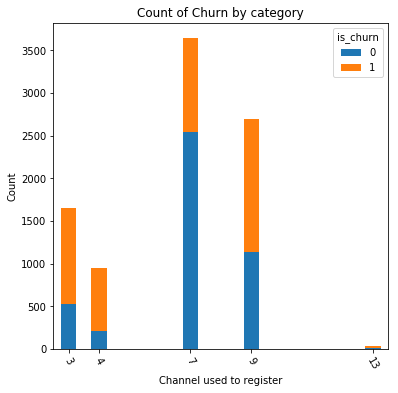

In [198]:
#  is churn by registration_channel
data_req = users.groupby(["registration_channel", "is_churn"]).size().unstack(level=1)
data_req.plot(kind="bar", stacked=True, figsize=(6, 6))
plt.title("Count of Churn by category")
plt.xlabel("Channel used to register", fontsize=10)
plt.xticks(rotation=300)
plt.ylabel("Count", fontsize=10)
plt.savefig("count_channel_churn.png")

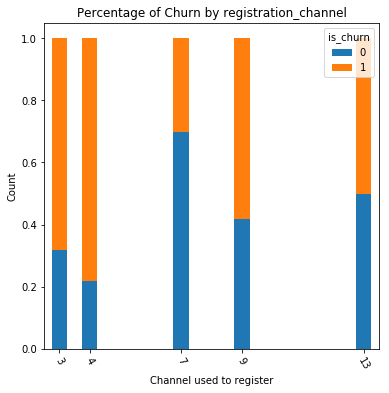

In [195]:
data_req = data_req.divide(users.groupby(["registration_channel"]).size(), axis=0)
data_req.plot(kind="bar", stacked=True, figsize=(6, 6))
plt.title("Percentage of Churn by registration_channel")
plt.xlabel("Channel used to register", fontsize=10)
plt.xticks(rotation=300)
plt.ylabel("Count", fontsize=10)
plt.savefig("churn percentage distribution registration channel.png")

> Le pourcentage de désabonnement par canal d'enregistrement montre aussi une différence de pourcentage de désabonnement pour les utilisateurs s'étant enregistrés suivant un canal. Néanmoins la différence de datapoints entre chaque canal ne pemets pas d'établir   l'impact sur le désabonnement. 

>Nous ne disposons pas d'assez de points pour le canal 13 pour affirmer qu'on obtient un taux de désabonnement plus important que pour le cannal 7 par exemple.

#### Impact du Canal d'enregistrement sur le désabonnement

Text(0, 0.5, 'Count')

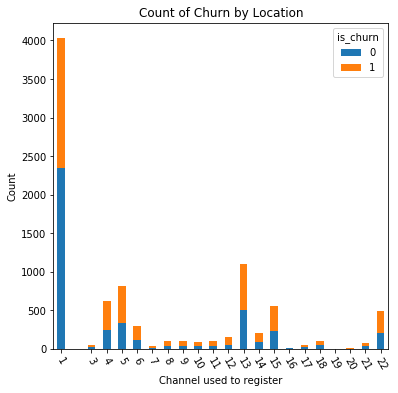

In [196]:
data_req = users.groupby(["location", "is_churn"]).size().unstack(level=1)
data_req.plot(kind="bar", stacked=True, figsize=(6, 6))
plt.title("Count of Churn by Location")
plt.xlabel("Channel used to register", fontsize=10)
plt.xticks(rotation=300)
plt.ylabel("Count", fontsize=10)

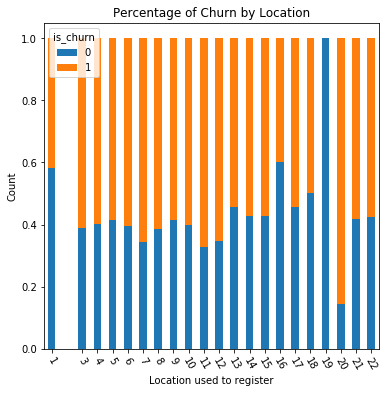

In [197]:
data_req = data_req.divide(users.groupby(["location"]).size(), axis=0)
data_req.plot(kind="bar", stacked=True, figsize=(6, 6))
plt.title("Percentage of Churn by Location")
plt.xlabel("Location used to register", fontsize=10)
plt.xticks(rotation=300)
plt.ylabel("Count", fontsize=10)

plt.savefig("churn percentage distribution location.png")

> L'analyse de la distribution des utilisateurs s'étant désabonnés par localisation, nous montre qu'à priori la localisation est moins impactante sur le désabonnement. 

> En effet nous avons un pourcentage de désabonnement entre 0.4 et 0.6 (sauf pour les localisations 19 et 20 qui représentent des outliers mais pas assez de points pour les deux localisations). Nous avons 1 user sur la localisation 19 et 5 sur la 20. La majorité des données proviennent de users localisé sur le site Id 1.

## Préparation des données

Avant d'appliquer un algorithme de clustering, nous avons réalisé plusieurs transformations sur les données. 

1. **Aggrégation** Nous avons aggréé 4 colonnes représentants la sommes des données loggés dans la table logs par utilisateurs
2. **Séparation en colonnes numériques et colonnes catégorique :** Cela permettera d'encoder les features catégoriques en one hot vector, ex : La localisation n'est pas  une donnée numérique.
4. **Scaling** : Nous allons scaler les données numériques

### Transformation des données

In [99]:
print(
    f"Nous avons {np.abs(len(set(logs.index))-len(set(users.index)))} users de différence entre les tables logs et le dataset user"
)

Nous avons 76 users de différence entre les tables logs et le dataset user


In [5]:
agg_logs = logs.drop(columns="date").groupby("uid").agg("sum")
agg_logs.head()

,views,items,duration,previews
uid,,,,
0,2634,6640,883533.0,4544
1,22987,24674,6465043.0,7135
2,52439,36158,13512932.0,4897
3,5337,6734,1481273.0,2000
4,20663,18346,5194508.0,7196


In [6]:
# Feature engineering
users["days_registered"] = (pd.Timestamp.now() - users["registration_date"]).dt.days
users.drop(columns=["registration_date"], inplace=True)

In [7]:
result = users.join(agg_logs, on="uid")
result.head()

,location,age,gender,registration_channel,is_churn,days_registered,views,items,duration,previews
uid,,,,,,,,,,
0,15,17,female,3,1,2299,2634.0,6640.0,883533.0,4544.0
1,13,40,female,9,0,5369,22987.0,24674.0,6465043.0,7135.0
2,14,23,male,9,1,5066,52439.0,36158.0,13512932.0,4897.0
3,1,19,female,3,1,2287,5337.0,6734.0,1481273.0,2000.0
4,1,0,NaN,9,1,2281,20663.0,18346.0,5194508.0,7196.0


In [8]:
result.shape

(8979, 10)

In [9]:
categorical_features = list(
    result.dtypes.where(result.dtypes == object).dropna().index
) + ["registration_channel", "location"]

numeric_features = list(result.dtypes.where(result.dtypes != object).dropna().index)
numeric_features.remove("registration_channel")
numeric_features.remove("location")
numeric_features.remove("is_churn")

features = categorical_features + numeric_features
X = result[features]
y = result["is_churn"]

In [10]:
numeric_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="Not defined")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preproc = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

Nous avons donc transformer nos données d'entrée : 

In [100]:
print("Training on X  shape : ", X.shape)
print("Training on y  shape : ", y.shape)

Training on X  shape :  (8979, 9)
Training on y  shape :  (8979,)


In [101]:
X_t = preproc.fit_transform(X)
print("Training on X  shape : ", X_t.shape)
print("Training on y  shape : ", y.shape)

Training on X  shape :  (8979, 35)
Training on y  shape :  (8979,)


## Clustering

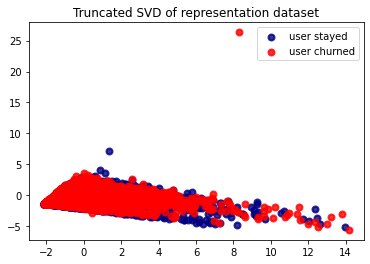

In [102]:
from sklearn.decomposition import PCA, TruncatedSVD

X_r = TruncatedSVD(n_components=2).fit_transform(X_t)

colors = ["navy", "red"]
lw = 2
target_names = ["user stayed", "user churned"]
for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(
        X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=0.8, lw=lw, label=target_name
    )


plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("Truncated SVD of representation dataset")

plt.savefig("TruncatedSVD.png")

> Nous ne remarquons pas de différence notable entre les deux distributions ( churn / stayed) en deux dimensions suite à l'ACP

##  Méthode 1 :  Prédiction par aggrégation

### Définir la métrique

Notre objectif est de détecter les utilisateurs suceptibles de quitter notre plateforme et de définir les features les plus impactantes. 

Nous voulons que la prédiction soit préventive afin de mettre en place des actions remédiants au désabonnement. Nous voulons détecter  le maximum possible d'utilisateurs et donc ne pas être précis n'est pas un  soucis car nous supposons que les actions menées pour remédier au désabonnement n'impacteront pas négativement les utilisateurs mal prédis.

Nous allons donc prendre le **recall** comme métrique où : 

$$recall  =True Positive / (True Positive +False Negative)$$



### Spot check

Notre méthode se basera sur une approche de spot checking sur plusieurs classes d'algorithmes pour la classification. 

Cette première approche nous permettera de détecter rapidement les algorithmes offrant le meilleur recall. 

La deuxième étape sera d'optimiser les hyperparametres du meilleur modèle retenu pour le recall.

In [144]:
ml_models = [
    ("dummy_stratified", DummyClassifier(strategy="stratified")),
    ("logistic_reg", LogisticRegression(n_jobs=-1)),
    ("decision_tree", DecisionTreeClassifier(criterion="gini")),
    ("random_forest", RandomForestClassifier(n_jobs=-1)),
]

model_score = {}

for name, model in ml_models:
    scores = cross_val_score(model, X_t, y, scoring="recall", cv=10, n_jobs=-1)
    model_score[name] = {
        "score": scores,
        "mean_score": np.mean(scores),
        "std_score": np.std(scores),
    }

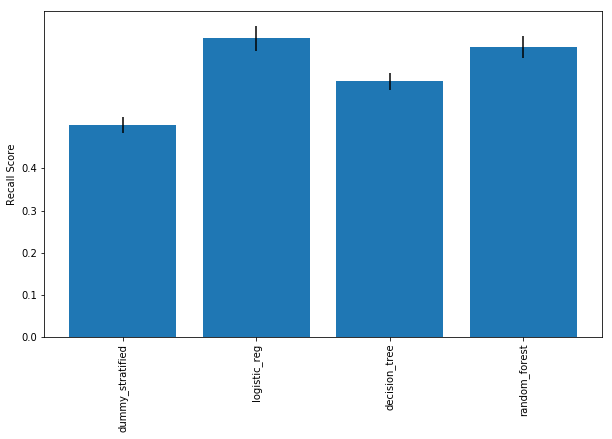

In [149]:
model_results = pd.DataFrame(model_score)

model_results.to_csv("spot check result")
ind = np.arange(model_results.loc["mean_score"].shape[0])
plt.figure(figsize=(10, 6))

plt.bar(
    ind,
    height=model_results.loc["mean_score"].values,
    yerr=model_results.loc["std_score"],
)
plt.xticks(ind, list(model_results.columns), rotation="vertical")
plt.yticks(np.arange(0, 0.5, 0.1))
plt.ylabel("Recall Score")


plt.savefig("Spot check model.png")

> Avec plusieurs essais avec 10 cross validation, nous remarquons que le random forest offre le meilleur score avec le moins de variance entre les folds.

#### Hyperparameter tuning

Nous avons choisi d'optimiser le random forest sur VM. Nous avons pickle le modèle qui est assez volumineux.

Les paramètres utilisés sont ceux ci dessous : 

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X_t, y, test_size=0.2)



````python
params =  {'random_forest__n_estimators': [500,800,900]}

params = {'random_forest__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
 'random_forest__max_features': ['auto', 'sqrt'],
 'random_forest__min_samples_leaf': [1, 2, 4],
 'random_forest__min_samples_split': [2, 5, 10],
 'random_forest__n_estimators': [200, 400, 600, 1000, 1200, 1400, 1600, 1800, 2000]}


pipe = Pipeline(steps=[('preprocessor', preproc), ("random_forest", RandomForestClassifier(n_jobs=-1))])
clf = GridSearchCV(pipe, params, cv=3,scoring='recall',n_jobs=-1)
clf.fit(X_train, y_train)

# On local Machine 
params = {"n_estimators": [500, 800, 900]}

clf = GridSearchCV(RandomForestClassifier(), params, cv=3, scoring="recall")
clf.fit(X_train, y_train)

print("Results for Random Forest")
print(clf.best_score_)

print(clf.best_params_)


pkl_filename = "pickled_random_forest.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf, file)
````


### Résultats

In [77]:
pkl_filename = "pickled_random_forest.pkl"

with open(pkl_filename, "rb") as file:
    clf = pickle.load(file)

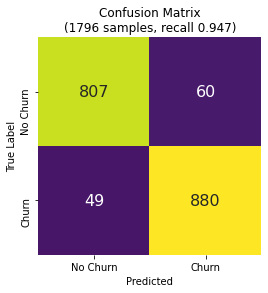

In [110]:
y_pred = clf.predict(X_test)

# Change this function
def plot_confusion_matrix(y, y_hat_prob, labels):
    y_hat = np.where(y_hat_prob > 0.5, 1, 0)  # probability to 0-1 binary
    cm = confusion_matrix(y, y_hat)
    recall = recall_score(y, y_hat)
    plt.figure(figsize=(4, 4))
    fig = sns.heatmap(
        cm,
        xticklabels=labels,
        yticklabels=labels,
        annot=True,
        cbar=False,
        fmt="d",
        annot_kws={"size": 16},
        cmap="viridis",
        vmin=0.2,
    )
    plt.title(f"Confusion Matrix\n({len(y)} samples, recall {recall:.3f})")
    plt.ylabel("True Label")
    plt.xlabel("Predicted")
    plt.show()
    fig.figure.savefig("confusion_RF.png")


plot_confusion_matrix(y_test, y_pred, ["No Churn", "Churn"])

Nous remarquons que nous prédisons correctement les utilisateurs qui choisissent de se désabonner. 

L'étape d'après sera de regarder les features permettants d'expliquer les raisons du désabonnement.

Les randoms forests permettent de voir l'importances de certaines features. Ce calcul est basé sur la contribution moyenne de chaque feature dans les arbres pour réduire l'indice Gini. 

Les features classées en premier impactent le plus la classfication et sont donc les raisons les plus plausibles de désabonnement.

In [79]:
ohe = preproc.named_transformers_["cat"].named_steps["onehot"]

feature_names = ohe.get_feature_names(input_features=categorical_features)

feature_names = np.r_[numeric_features, feature_names]

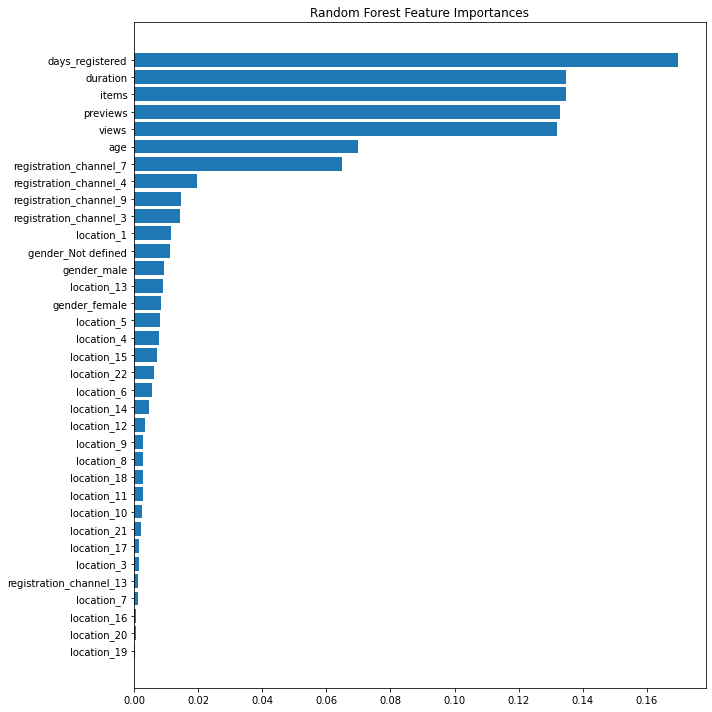

In [84]:
importances = clf.best_estimator_.feature_importances_

sorted_idx = importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=(10, 10))
ax.barh(y_ticks, importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances")
fig.tight_layout()
plt.show()

fig.savefig("feature_importance_RF.png")

Nous remarquons que les features prédites sont: 
 * le nombre de jours enregistré: plus une personnes est inscrite moins elle va se désabonner.
 * duration, items,previews,views : plus la personne est enregistré longtemps et plus elle consomme du contenu média moins elle va se désabonner
 * L'age est aussi un bon prédicteur de désabonnement 

La méthode feature_importance nous donne un classement de feature qui est rapide mais est biaisée pour classer en premier les variables continues par exemple.. 

Nous allons tester une autre méthode : **Permutation importance**.

In [162]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    clf, X_test, y_test, n_repeats=10, scoring="recall", n_jobs=-1
)

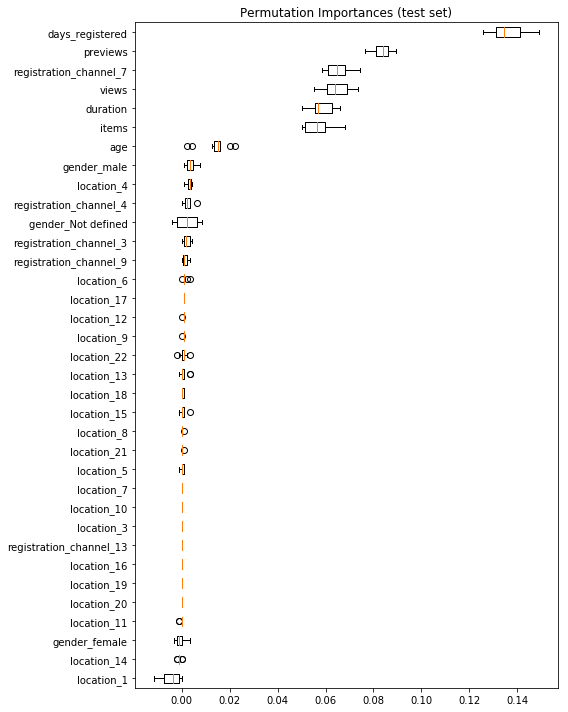

<Figure size 432x288 with 0 Axes>

In [164]:
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(8, 10))
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=feature_names[sorted_idx]
)
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()
plt.savefig("permutation_importance_rf")

Cette approche calcul directement la feature importance en : 

1. Calculant le score du modèle de base
2. Pour toutes les features : 
 1. On redistribue aléatoirement les valueurs pour une features, 
 2. On repasse les données au modèle pour obtenir les prédiction. 
 3. On calcul la feature importance en calculant la difference entre le score de base et le score apres shuffeling
 
 > Les résultats confirment ceux vus précédement avec l'ajout de la variable canal d'enregistrement 7 . Ce canal est celui où nous avons le plus de données, ce n'est donc pas une feature différenciante. 

## Méthode 2 : Prédiction sequentielle avec méchanisme d'attention

La seconde méthode est une approche qui permet d'utiliser les données temporelles des logs. 
En effet, nous avons aggréé les données temporelles d'une manière 'simple' dans la méthode 1. Cette compression  fait perdre beaucoup d'informations sur l'utilisation quotidienne de l'application. 

Nous espérons capturer l'impact des données temporelle sur la prédiction en construisant un modèle séquentielle avec un méchanisme d'attention. 

Le méchanisme d'attention a été ajouté afin de récupérer des poids d'attentions répartis sur le temps qui nous permetterons d'interpréter l'interaction des utilisateurs avec l'application en interprétant la variation des poids par utilisateurs.

Nous allons aussi concatener les informations profils dans une input séparéé et l'ajouter post méchanisque d'attention au Tenseur des logs.

In [113]:
X = pd.DataFrame.sparse.from_spmatrix(X_t, columns=feature_names.tolist())

In [114]:
X.head()

,age,days_registered,views,items,duration,previews,gender_Not defined,gender_female,gender_male,registration_channel_3,registration_channel_4,registration_channel_7,registration_channel_9,registration_channel_13,location_1,location_3,location_4,location_5,location_6,location_7,location_8,location_9,location_10,location_11,location_12,location_13,location_14,location_15,location_16,location_17,location_18,location_19,location_20,location_21,location_22
0,0.108217,-0.340354,-0.447067,-0.104045,-0.421232,0.665778,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.385434,2.590240,1.352034,1.712344,1.595694,1.431703,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.441404,2.300999,3.955440,2.869015,4.142508,0.770128,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.219280,-0.351809,-0.208136,-0.094577,-0.205233,-0.086254,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.835812,-0.357537,1.146604,1.074986,1.136575,1.449736,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Réparatition des logs par utilisateurs

Nous commencons par visualiser le nombre de logs par utilisateurs dans la table **logs**

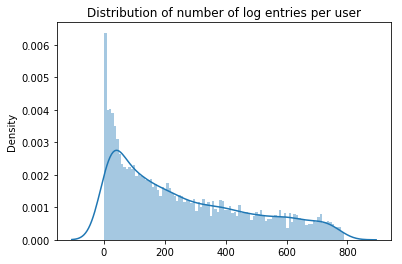

In [165]:
logs_dist = logs.groupby("uid").size()

sns.distplot(logs_dist, bins=100)
plt.title("Distribution of number of log entries per user")
plt.savefig("distrib_logs_per_users")

<AxesSubplot:xlabel='date', ylabel='views'>

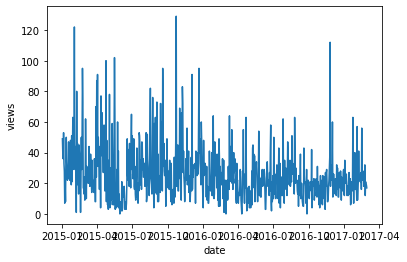

In [28]:
sns.lineplot(x="date", y="views", data=rlogs.loc[0])

### Data preparation

Nous allons préparer les séries temporelles pour avoir une input pour notre modèle.

Nous avons plusieurs challenges : 

* Les données utilisateurs ne sont pas calibrés sur la même période temporelle et nous ne disposons pas de points pour chaque jour entre le min(date(logs)) et max(date(logs)). 
* Les utilisateurs ne sont pas tous enregistré à la même date ce qui créé un décalage d'informations
* Nous avons trop de data de point puisque les logs ont été colletés sur plus de 2 ans

Afin de résoudre ces problèmes, nous proposons la démarche suivante : 
* Manuellement ajouter la date min et max pour chaque user
* Nous faisons le choix de set la valeur 0 pour les logs avant la date d'inscription et post la date de désinscription.
* Afin de réduire la dimension du problème nous aggréons les données sur une semaine. 

In [139]:
rlogs = logs.copy()
rlogs = rlogs.reset_index()
rlogs.tail()

,uid,date,views,items,duration,previews
2324209,8977,2016-06-14,8,21,2748.0,20
2324210,8977,2016-08-14,11,15,3175.0,7
2324211,8977,2016-10-25,9,7,2889.0,7
2324212,8977,2016-12-23,3,14,1865.0,16
2324213,8977,2017-02-15,7,8,1655.0,0


In [140]:
min_date = logs.date.min()
max_date = logs.date.max()
have_min_date = rlogs[rlogs.date == min_date].uid.values
have_max_date = rlogs[rlogs.date == max_date].uid.values

In [141]:
pbar = tqdm(set(logs.index))

for uid in pbar:
    pbar.set_description("Processing %s" % uid)
    dict_test = {
        "date": min_date,
        "uid": uid,
        "views": 0,
        "items": 0,
        "duration": 0,
        "previews": 0,
    }
    rlogs = rlogs.append(dict_test, ignore_index=True)
    dict_test = {
        "date": max_date,
        "uid": uid,
        "views": 0,
        "items": 0,
        "duration": 0,
        "previews": 0,
    }
    rlogs = rlogs.append(dict_test, ignore_index=True)

Processing 8978: 100%|██████████| 8903/8903 [26:51<00:00,  5.53it/s]


In [50]:
# rlogs.to_csv('result_pandas.csv')
rlogs = pd.read_csv("result_pandas.csv", parse_dates=True)
rlogs = rlogs.set_index("date")
rlogs.index = pd.to_datetime(rlogs.index)
rlogs.head()

,Unnamed: 0,uid,views,items,duration,previews
date,,,,,,
2015-02-18,0,1,5,10,2126.0,2
2015-04-12,1,1,12,14,3821.0,3
2015-06-01,2,1,4,7,1387.0,2
2015-07-22,3,1,12,30,5713.0,17
2015-09-12,4,1,40,40,10374.0,8


In [51]:
temp = rlogs.groupby("uid").resample("D").asfreq()
temp = temp.fillna(0)
result = temp.iloc[:, 2:]
#  result.to_csv('padded_logs.csv',index=True,compression="zip")

In [52]:
dum = result.reset_index().set_index("date")
dum = dum.groupby("uid").resample("W").sum()
#  dum.to_csv('padded_logs_weekly.csv',index=True, compression="zip")

In [82]:
#  dum.to_csv('padded_logs_weekly.csv',index=True)

In [22]:
res = pd.read_csv("padded_logs_weekly.csv", index_col=["uid", "date"]).iloc[:, 1:]

Nous pouvons tracer les séries de logs durée de deux utilisateurs post traitement :

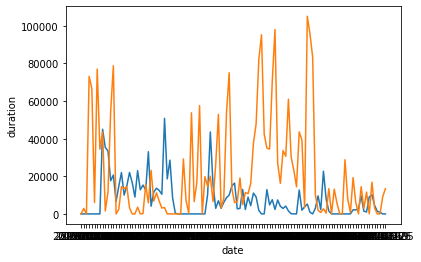

In [23]:
sns.lineplot(x="date", y="duration", data=res.loc[0])
sns.lineplot(x="date", y="duration", data=res.loc[456])

plt.savefig("post_treatment.png")

### LSTM Input

In [115]:
#  input is of shape : nb_users x events x features
# if users in DF users but no logs , means probably he never connected to the app we will assign to him the null vector
nb_missing_ulogs = (
    users.index.shape[0] - res.index.get_level_values(0).unique().shape[0]
)
print("Nous n'avons pas de logs pour {} users".format(nb_missing_ulogs))

Nous n'avons pas de logs pour 76 users


Nous pouvons inférer que ces utilisateurs ne se sont jamais connecté à l'application par exemple.

Il suffit donc de set leurs valeurs de logs à 0.

Préparation des données :

In [24]:
nb_users = len(set(users.index))
events = res.loc[0].shape[0]
n_features = res.loc[0].shape[1]

In [70]:
X1 = np.zeros((nb_users, events, n_features))
pbar = tqdm(set(users.index))

for uid in pbar:
    if uid in res.index.get_level_values(0).unique():
        # X1[uid, : , :] = res_numpy[uid]
        X1[uid, :, :] = res.loc[uid].to_numpy()

100%|██████████| 8979/8979 [04:52<00:00, 30.69it/s]


In [13]:
pkl_filename = "pickled_input_tensor.pkl"

# with open(pkl_filename, 'wb') as file:
#    pickle.dump(X1, file)

with open(pkl_filename, "rb") as file:
    X1 = pickle.load(file)

In [14]:
X_logs_train, X_logs_test, X_train, X_test, y_train, y_test = train_test_split(
    X1, X_t.toarray(), y, test_size=0.2
)

In [15]:
scaler = StandardScaler()
X_logs_train = scaler.fit_transform(
    X_logs_train.reshape(-1, X_logs_train.shape[-1])
).reshape(X_logs_train.shape)
X_logs_test = scaler.transform(X_logs_test.reshape(-1, X_logs_test.shape[-1])).reshape(
    X_logs_test.shape
)

In [117]:
print(f"Input tensors shapes: X - Logs {X1.shape}, x {X_t.shape}")
print(f"Output shape: y {y.shape}")
print("Nous avons {} logs et profiles pour le  training".format(X_logs_train.shape[0]))
print("Et {}  logs et profiles pour le testing".format(X_logs_test.shape[0]))

Input tensors shapes: X - Logs (8979, 114, 4), x (8979, 35)
Output shape: y (8979,)
Nous avons 7183 logs et profiles pour le  training
Et 1796  logs et profiles pour le testing


### Modèle

1. Nous construisons le modèle séquentielle en LSTM en intégrant un méchanisme d'attention pour l'input des logs.
2. Ce méchanisme permet de choisir à chaque instant un vecteur contexte issue du layer d'attention . Cela permet d'assigner plus ou moins de l'importance aux valeurs temporelles des logs via des poids d'attentions.
3. Nous combine ensuite l'input issu du profil puis nous ajoutons deux layers fully connected 

In [25]:
hidden_units = 8

input_logs = Input(shape=(events, n_features))
input_user = Input(shape=(X_t.shape[1],))

activations = LSTM(hidden_units, return_sequences=True)(input_logs)

attention = Dense(1, activation="tanh")(activations)
attention = Flatten()(attention)
attention = Activation("softmax", name="attention_weigths")(attention)
attention = RepeatVector(hidden_units * 1)(attention)
attention = Permute([2, 1])(attention)

weighted_activations = Multiply()([activations, attention])
weighted_activations = Lambda(
    lambda x: K.sum(x, axis=-2), output_shape=(hidden_units,)
)(weighted_activations)

lstm = Model(inputs=input_logs, outputs=weighted_activations)

profile_out = Dense(16, activation="relu")(input_user)
profile = Model(inputs=input_user, outputs=profile_out)

combined = Concatenate()([lstm.output, profile.output])
dense_top = Dense(32, activation="relu")(combined)
prob_churn = Dense(1, activation="sigmoid")(dense_top)

model = Model(inputs=[lstm_tower.input, profile_tower.input], outputs=prob_churn)

In [26]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 114, 4)]     0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 114, 8)       416         input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 114, 1)       9           lstm[0][0]                       
__________________________________________________________________________________________________
flatten (Flatten)               (None, 114)          0           dense[0][0]                      
_______________________________________________________________________________________

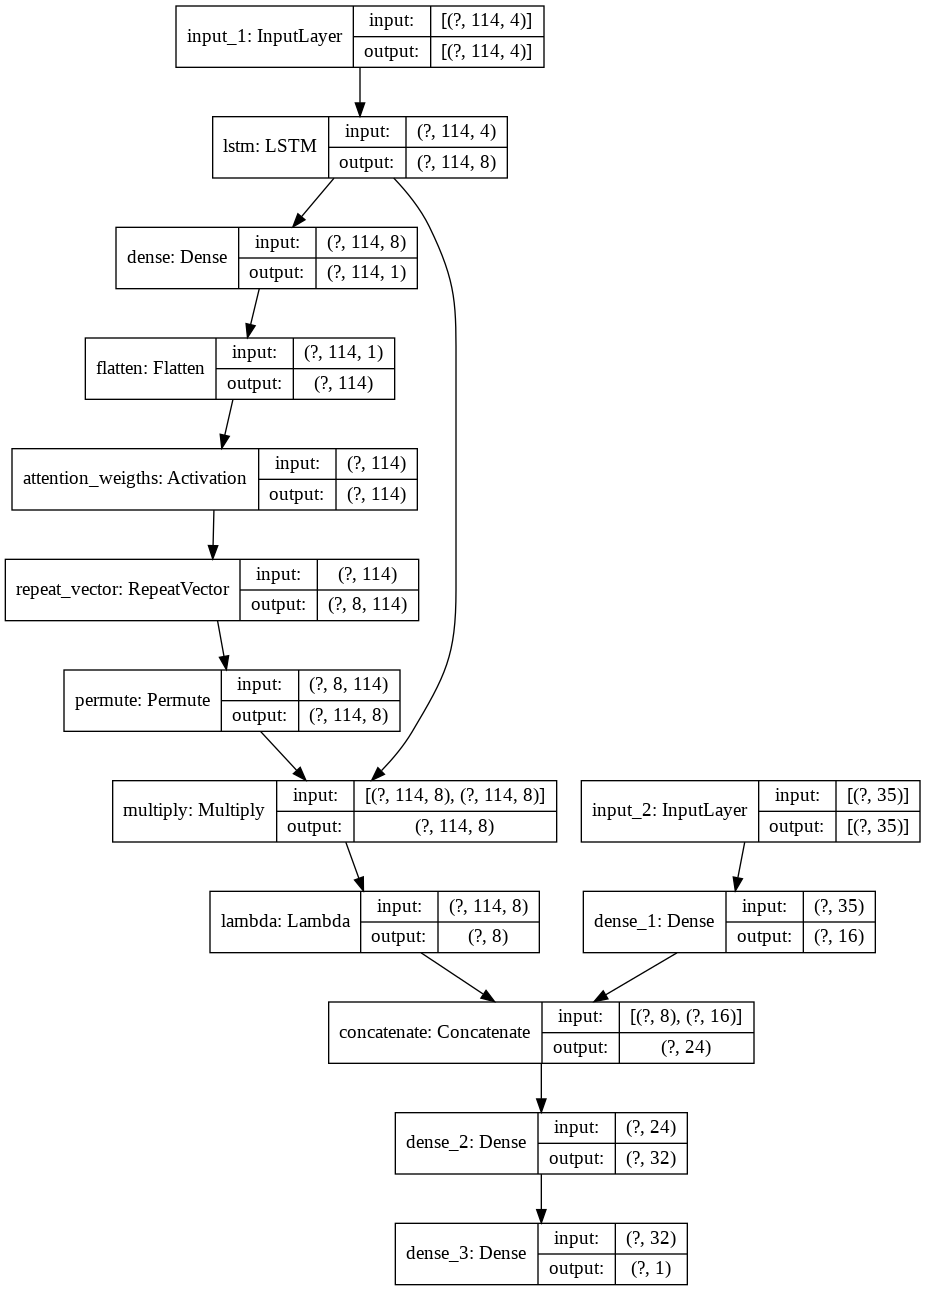

In [27]:
plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

### Training

Nous entrainons le modèle LSTM avec attention en utilisant les données X_logs et X profiles. Nous ajoutons un méchanisme d'arrêt automatique quand la loss entre 5 itérations n'est pas significativement réduite.

Nous enregistrons le recall en même temps que l'accuracy pour ce modèle.

In [28]:
es = EarlyStopping(monitor="val_loss", mode="min", patience=5)

model.compile(
    optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy", Recall()]
)
history = model.fit(
    [X_logs_train, X_train],
    y_train,
    batch_size=32,
    epochs=20,
    verbose=1,
    validation_data=([X_logs_test, X_test], y_test),
    callbacks=[es],
)

score = model.evaluate([X_logs_test, X_test], y_test, verbose=0)

Epoch 1/20
225/225 [==============================] - 7s 32ms/step - loss: 0.6508 - accuracy: 0.6385 - recall: 0.6465 - val_loss: 0.6271 - val_accuracy: 0.6598 - val_recall: 0.6770
Epoch 2/20
225/225 [==============================] - 7s 32ms/step - loss: 0.6146 - accuracy: 0.6751 - recall: 0.6820 - val_loss: 0.6210 - val_accuracy: 0.6704 - val_recall: 0.6678
Epoch 3/20
225/225 [==============================] - 7s 29ms/step - loss: 0.6083 - accuracy: 0.6792 - recall: 0.6772 - val_loss: 0.6158 - val_accuracy: 0.6771 - val_recall: 0.6598
Epoch 4/20
225/225 [==============================] - 6s 28ms/step - loss: 0.6046 - accuracy: 0.6834 - recall: 0.6755 - val_loss: 0.6178 - val_accuracy: 0.6771 - val_recall: 0.6793
Epoch 5/20
225/225 [==============================] - 6s 28ms/step - loss: 0.6016 - accuracy: 0.6858 - recall: 0.6758 - val_loss: 0.6199 - val_accuracy: 0.6659 - val_recall: 0.6977
Epoch 6/20
225/225 [==============================] - 7s 31ms/step - loss: 0.5988 - accuracy: 0

In [310]:
model.save_weights("attention_model_weight.h5")
model.save("attention_model.h5")

In [180]:
status = model.load_weights("attention_model_weight.h5")

### Résultats training 

> Nous remarquons que le modèle overfit sur les données. Nous n'avons pas eu le temps d'introduire un méchanisme de régulation en ajouter des layers de dropout ou des layers [regulizer](https://keras.io/api/layers/regularizers/).

> Nous pouvons néanmoins analyser les résultats intermédiaires sur les données de tests.

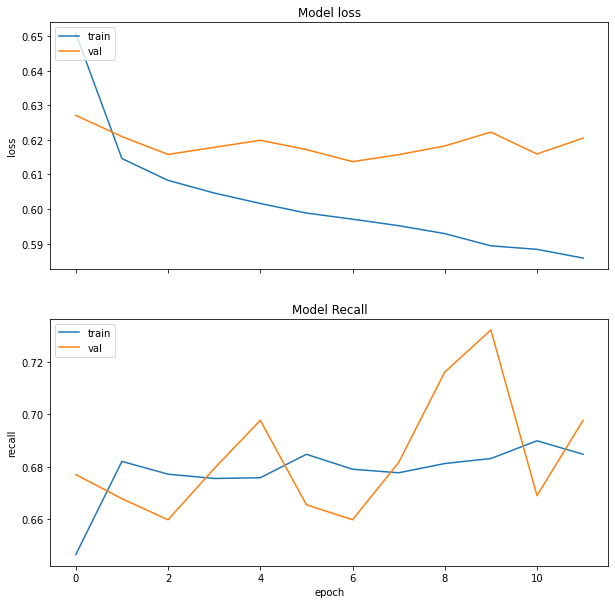

In [192]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(10, 10))
axs[0].plot(history.history["loss"])
axs[0].plot(history.history["val_loss"])
axs[0].set_title("Model loss")
axs[0].set_ylabel("loss")
axs[0].legend(["train", "val"], loc="upper left")

axs[1].plot(history.history["recall"])
axs[1].plot(history.history["val_recall"])
axs[1].set_title("Model Recall")
axs[1].set_ylabel("recall")
axs[1].set_xlabel("epoch")
axs[1].legend(["train", "val"], loc="upper left")

plt.savefig("training_lstm_with_attention.png")

### Résultats

> Les prédictions du modèles sont moins précises que celles des Random forest avec aggregation. Néanmoins ce modèle n'a pas été "fine tuned", nous pouvons améliorer ces résultats avec plus de temps d'entrainement et/ou des modifications d'architecture. 

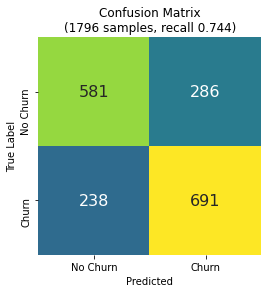

In [123]:
y_pred = model.predict([X_logs_test, X_test])

# plot confusion matrix
plot_confusion_matrix(y_test, y_pred, ["No Churn", "Churn"])

### Analyse des points d'attention


L'un des avantages de ce modèle est de récupérer les poids des attentions du modèle. Prenons par exemple  des poids pour l'utilisateur UID 4572. 

Nous remarquons que plus l'utilisateur utilise l'application moins les poids sont importants et donc moins il a tendance à se désabonner. 

Plus un utilisateur reste sans se connecter plus l'attention pour le désabonnement augmente.

In [175]:
attention = Model(
    inputs=model.input, outputs=model.get_layer("attention_weigths").output
)
a = attention.predict([X_logs_test, X_test])

Poids d'attentions pour l'utilisateur 4572


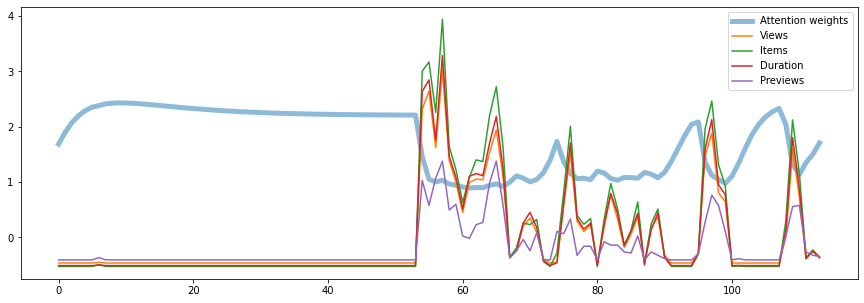

In [205]:
p = 32
print("Poids d'attentions pour l'utilisateur", y_test.index[p])
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(200*a[p, :], label="Attention weights", linewidth=5, alpha=0.5)
for i, column in zip(range(n_features), ["Views", "Items", "Duration", "Previews"]):
    ax.plot(X_logs_test[p][:, i], label=column)
    ax.legend()
plt.savefig("attention.png")

# Conclusion

Nous avons utilisé deux méthodes pour la prédiction de désabonnement, la première basée sur l'aggrégation des données de logs et données profiles et une deuxième basé sur une approche de modélisation séquentielle.

Le random forest nous a donné les meilleurs résultats de prédiction, mais ce modèle ne permet pas de détecter clairement des patterns d'utilisations entrainant le désabonnement. Le deuxième modèle nous a permis de representer la contribution des évènements sur le désabonnement via les poids d'attention.

Nous pouvons explorer d'autres méthodes en regroupant les points d'attentions des utilisateurs pour détecter les clusters d'utilisation. 

Nous retenons que les raisons du désabonnement des utilisateurs de la plateforme dans ces deux méthodes sont :
* Les facteurs les plus importants sont le temps que l'utilisateurs passent sur l'application, le nombre d'interaction de l'utilisateur et la fréquence de connexion.
* La localisation des utilisateurs n'a pas d'impact conséquent sur la prédiction désabonnement 

Cette analyse permet donc de détecter les utilisateurs suceptibles de se désabonner en avance et nous encourage aussi à maximiser le temps d'utilisation de l'application. Le développement et le test de nouvelles fonctionnalités permettant de garder le plus longtemps possible l'utilisateur interactif avec l'application, le rappels de connexions, l'envoi de notifications pourront être des pistes d'amélioration de l'application permettant de réduire le taux de désabonnement.